***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_dominio_tiempo_frecuencia/longitud_8/raw-img-v5')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 13668
class_name
AIS(37)       4160
AIS(31-32)    3260
AIS(70-79)    1216
AIS(90-99)    1058
AIS(36)       1014
AIS(60-69)     993
AIS(30)        896
AIS(80-89)     570
AIS(52)        310
AIS(56-57)     191
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 10937
class_name
AIS(37)       3328
AIS(31-32)    2608
AIS(70-79)     973
AIS(90-99)     847
AIS(36)        812
AIS(60-69)     795
AIS(30)        717
AIS(80-89)     456
AIS(52)        248
AIS(56-57)     153
Name: count, dtype: int64

Nº de imágenes en test: 2731
class_name
AIS(37)       832
AIS(31-32)    652
AIS(70-79)    243
AIS(90-99)    211
AIS(36)       202
AIS(60-69)    198
AIS(30)       179
AIS(80-89)    114
AIS(52)        62
AIS(56-57)     38
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name  class_name
0  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(37)
1  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(31-32)
2  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(60-69)
3  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(36)
4  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(37)
5  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(56-57)
6  Imagenes\Trayec

***Imágenes de entrenamiento y test antes del pre-procesado :***

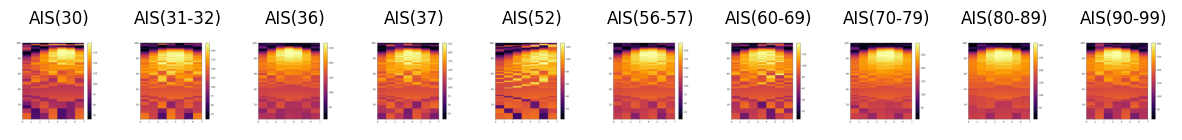

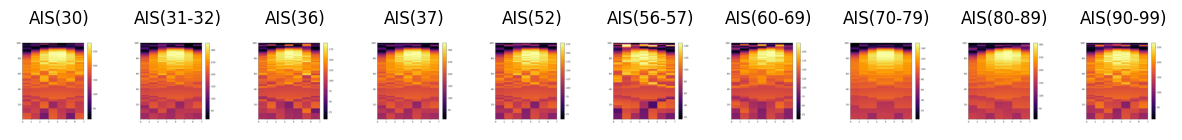

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([10937, 3, 227, 227]) cpu
y_train: torch.Size([10937]) cpu
X_test: torch.Size([2731, 3, 227, 227]) cpu
y_test: torch.Size([2731]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [6]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [6]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    nombre_modelo = "ResNet50"
    modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "ConvNext_Tiny"
    #modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v5/representacion_3/longitud_8"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 274/274 [01:22<00:00,  3.32it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 15.65% - Train Loss: 2.2849 | Val Acc: 10.60% - Val Loss: 2.2527


Fold 1 | Epoch 2/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 22.08% - Train Loss: 2.1855 | Val Acc: 9.41% - Val Loss: 2.2886


Fold 1 | Epoch 3/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 22.76% - Train Loss: 2.1310 | Val Acc: 18.28% - Val Loss: 2.3214


Fold 1 | Epoch 4/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 24.17% - Train Loss: 2.0866 | Val Acc: 17.28% - Val Loss: 2.2898


Fold 1 | Epoch 5/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 26.57% - Train Loss: 2.0424 | Val Acc: 19.65% - Val Loss: 2.3083


Fold 1 | Epoch 6/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 27.24% - Train Loss: 2.0035 | Val Acc: 10.88% - Val Loss: 2.3100


Fold 1 | Epoch 7/100: 100%|██████████| 274/274 [01:03<00:00,  4.28it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 28.27% - Train Loss: 1.9670 | Val Acc: 26.28% - Val Loss: 2.3061


Fold 1 | Epoch 8/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 29.65% - Train Loss: 1.9407 | Val Acc: 17.60% - Val Loss: 2.3295


Fold 1 | Epoch 9/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 30.56% - Train Loss: 1.9061 | Val Acc: 11.75% - Val Loss: 2.3363


Fold 1 | Epoch 10/100: 100%|██████████| 274/274 [01:04<00:00,  4.28it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 31.44% - Train Loss: 1.8786 | Val Acc: 14.49% - Val Loss: 2.3450


Fold 1 | Epoch 11/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 32.00% - Train Loss: 1.8498 | Val Acc: 20.89% - Val Loss: 2.3441


Fold 1 | Epoch 12/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 32.77% - Train Loss: 1.8302 | Val Acc: 18.92% - Val Loss: 2.3321


Fold 1 | Epoch 13/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 33.26% - Train Loss: 1.8034 | Val Acc: 14.40% - Val Loss: 2.3505


Fold 1 | Epoch 14/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 33.64% - Train Loss: 1.7947 | Val Acc: 16.41% - Val Loss: 2.3756


Fold 1 | Epoch 15/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 34.34% - Train Loss: 1.7575 | Val Acc: 15.08% - Val Loss: 2.3499


Fold 1 | Epoch 16/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 34.19% - Train Loss: 1.7408 | Val Acc: 21.07% - Val Loss: 2.3856


Fold 1 | Epoch 17/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 35.36% - Train Loss: 1.7194 | Val Acc: 15.36% - Val Loss: 2.3970


Fold 1 | Epoch 18/100: 100%|██████████| 274/274 [01:01<00:00,  4.46it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 36.04% - Train Loss: 1.7064 | Val Acc: 18.69% - Val Loss: 2.3981


Fold 1 | Epoch 19/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 36.26% - Train Loss: 1.6898 | Val Acc: 16.45% - Val Loss: 2.4433


Fold 1 | Epoch 20/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 37.36% - Train Loss: 1.6722 | Val Acc: 20.93% - Val Loss: 2.4318


Fold 1 | Epoch 21/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 37.57% - Train Loss: 1.6582 | Val Acc: 15.49% - Val Loss: 2.4618


Fold 1 | Epoch 22/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 38.03% - Train Loss: 1.6385 | Val Acc: 20.89% - Val Loss: 2.4201


Fold 1 | Epoch 23/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 38.16% - Train Loss: 1.6255 | Val Acc: 15.77% - Val Loss: 2.4294


Fold 1 | Epoch 24/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 38.71% - Train Loss: 1.6106 | Val Acc: 16.18% - Val Loss: 2.4403


Fold 1 | Epoch 25/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 38.92% - Train Loss: 1.5887 | Val Acc: 19.01% - Val Loss: 2.4424


Fold 1 | Epoch 26/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 39.88% - Train Loss: 1.5923 | Val Acc: 18.74% - Val Loss: 2.4639


Fold 1 | Epoch 27/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 40.48% - Train Loss: 1.5653 | Val Acc: 20.93% - Val Loss: 2.5141


Fold 1 | Epoch 28/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 39.96% - Train Loss: 1.5661 | Val Acc: 19.20% - Val Loss: 2.4597


Fold 1 | Epoch 29/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 40.42% - Train Loss: 1.5467 | Val Acc: 21.21% - Val Loss: 2.5171


Fold 1 | Epoch 30/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 40.24% - Train Loss: 1.5343 | Val Acc: 19.15% - Val Loss: 2.4910


Fold 1 | Epoch 31/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 40.68% - Train Loss: 1.5266 | Val Acc: 23.17% - Val Loss: 2.5179


Fold 1 | Epoch 32/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 41.82% - Train Loss: 1.5081 | Val Acc: 16.77% - Val Loss: 2.5094


Fold 1 | Epoch 33/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 41.92% - Train Loss: 1.4945 | Val Acc: 16.32% - Val Loss: 2.4984


Fold 1 | Epoch 34/100: 100%|██████████| 274/274 [01:01<00:00,  4.45it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 42.10% - Train Loss: 1.4928 | Val Acc: 20.84% - Val Loss: 2.5420


Fold 1 | Epoch 35/100: 100%|██████████| 274/274 [01:03<00:00,  4.31it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 42.52% - Train Loss: 1.4833 | Val Acc: 16.54% - Val Loss: 2.5679


Fold 1 | Epoch 36/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 42.40% - Train Loss: 1.4691 | Val Acc: 15.40% - Val Loss: 2.5335


Fold 1 | Epoch 37/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 41.87% - Train Loss: 1.4649 | Val Acc: 19.47% - Val Loss: 2.5696


Fold 1 | Epoch 38/100: 100%|██████████| 274/274 [01:03<00:00,  4.30it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 43.35% - Train Loss: 1.4464 | Val Acc: 15.17% - Val Loss: 2.5566


Fold 1 | Epoch 39/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 43.31% - Train Loss: 1.4421 | Val Acc: 18.97% - Val Loss: 2.6067


Fold 1 | Epoch 40/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 43.23% - Train Loss: 1.4253 | Val Acc: 15.13% - Val Loss: 2.5912


Fold 1 | Epoch 41/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 42.34% - Train Loss: 1.4260 | Val Acc: 17.46% - Val Loss: 2.5775


Fold 1 | Epoch 42/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 43.94% - Train Loss: 1.4260 | Val Acc: 18.24% - Val Loss: 2.6009


Fold 1 | Epoch 43/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 44.13% - Train Loss: 1.4032 | Val Acc: 18.46% - Val Loss: 2.5942


Fold 1 | Epoch 44/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 43.74% - Train Loss: 1.4028 | Val Acc: 17.87% - Val Loss: 2.6022


Fold 1 | Epoch 45/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 44.13% - Train Loss: 1.3865 | Val Acc: 18.83% - Val Loss: 2.6541


Fold 1 | Epoch 46/100: 100%|██████████| 274/274 [01:01<00:00,  4.45it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 44.84% - Train Loss: 1.3886 | Val Acc: 15.90% - Val Loss: 2.6239


Fold 1 | Epoch 47/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 44.93% - Train Loss: 1.3773 | Val Acc: 14.03% - Val Loss: 2.6713


Fold 1 | Epoch 48/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 44.71% - Train Loss: 1.3697 | Val Acc: 20.43% - Val Loss: 2.6689


Fold 1 | Epoch 49/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 44.62% - Train Loss: 1.3624 | Val Acc: 20.75% - Val Loss: 2.6684


Fold 1 | Epoch 50/100: 100%|██████████| 274/274 [01:01<00:00,  4.46it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 44.91% - Train Loss: 1.3545 | Val Acc: 18.01% - Val Loss: 2.6518


Fold 1 | Epoch 51/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 45.66% - Train Loss: 1.3408 | Val Acc: 18.01% - Val Loss: 2.6625


Fold 1 | Epoch 52/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 46.41% - Train Loss: 1.3390 | Val Acc: 18.14% - Val Loss: 2.6620


Fold 1 | Epoch 53/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 46.17% - Train Loss: 1.3399 | Val Acc: 16.91% - Val Loss: 2.6813


Fold 1 | Epoch 54/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 45.64% - Train Loss: 1.3263 | Val Acc: 14.58% - Val Loss: 2.6726


Fold 1 | Epoch 55/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 46.47% - Train Loss: 1.3196 | Val Acc: 18.05% - Val Loss: 2.6767


Fold 1 | Epoch 56/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 45.87% - Train Loss: 1.3170 | Val Acc: 17.92% - Val Loss: 2.7696


Fold 1 | Epoch 57/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 46.06% - Train Loss: 1.3080 | Val Acc: 17.69% - Val Loss: 2.7237


Fold 1 | Epoch 58/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 46.49% - Train Loss: 1.3028 | Val Acc: 18.05% - Val Loss: 2.7031


Fold 1 | Epoch 59/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 45.57% - Train Loss: 1.2996 | Val Acc: 17.14% - Val Loss: 2.7451


Fold 1 | Epoch 60/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 46.99% - Train Loss: 1.2971 | Val Acc: 13.48% - Val Loss: 2.6967


Fold 1 | Epoch 61/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 46.82% - Train Loss: 1.2962 | Val Acc: 16.68% - Val Loss: 2.7333


Fold 1 | Epoch 62/100: 100%|██████████| 274/274 [01:01<00:00,  4.44it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 47.45% - Train Loss: 1.2831 | Val Acc: 16.09% - Val Loss: 2.7330


Fold 1 | Epoch 63/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 46.30% - Train Loss: 1.2878 | Val Acc: 17.46% - Val Loss: 2.7338


Fold 1 | Epoch 64/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 47.71% - Train Loss: 1.2666 | Val Acc: 16.00% - Val Loss: 2.7838


Fold 1 | Epoch 65/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 46.67% - Train Loss: 1.2823 | Val Acc: 19.56% - Val Loss: 2.7998


Fold 1 | Epoch 66/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 47.64% - Train Loss: 1.2599 | Val Acc: 16.00% - Val Loss: 2.7741


Fold 1 | Epoch 67/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 47.69% - Train Loss: 1.2623 | Val Acc: 18.65% - Val Loss: 2.7923


Fold 1 | Epoch 68/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 47.49% - Train Loss: 1.2576 | Val Acc: 18.01% - Val Loss: 2.7693


Fold 1 | Epoch 69/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 48.04% - Train Loss: 1.2465 | Val Acc: 19.29% - Val Loss: 2.8113


Fold 1 | Epoch 70/100: 100%|██████████| 274/274 [01:01<00:00,  4.45it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 47.46% - Train Loss: 1.2442 | Val Acc: 15.90% - Val Loss: 2.7955


Fold 1 | Epoch 71/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 48.20% - Train Loss: 1.2424 | Val Acc: 19.33% - Val Loss: 2.8865


Fold 1 | Epoch 72/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 48.27% - Train Loss: 1.2292 | Val Acc: 17.09% - Val Loss: 2.8026


Fold 1 | Epoch 73/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 47.97% - Train Loss: 1.2332 | Val Acc: 15.13% - Val Loss: 2.8283


Fold 1 | Epoch 74/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 47.41% - Train Loss: 1.2382 | Val Acc: 13.62% - Val Loss: 2.8546


Fold 1 | Epoch 75/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 48.35% - Train Loss: 1.2191 | Val Acc: 17.60% - Val Loss: 2.8564


Fold 1 | Epoch 76/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 48.01% - Train Loss: 1.2236 | Val Acc: 18.74% - Val Loss: 2.8366


Fold 1 | Epoch 77/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 48.54% - Train Loss: 1.2156 | Val Acc: 17.92% - Val Loss: 2.8707


Fold 1 | Epoch 78/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 48.53% - Train Loss: 1.2139 | Val Acc: 16.00% - Val Loss: 2.8393


Fold 1 | Epoch 79/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 49.25% - Train Loss: 1.2066 | Val Acc: 14.85% - Val Loss: 2.8999


Fold 1 | Epoch 80/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 48.47% - Train Loss: 1.1989 | Val Acc: 16.32% - Val Loss: 2.8456


Fold 1 | Epoch 81/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 48.89% - Train Loss: 1.2095 | Val Acc: 19.29% - Val Loss: 2.8868


Fold 1 | Epoch 82/100: 100%|██████████| 274/274 [01:01<00:00,  4.46it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 48.99% - Train Loss: 1.2029 | Val Acc: 17.37% - Val Loss: 2.9113


Fold 1 | Epoch 83/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 48.65% - Train Loss: 1.1935 | Val Acc: 17.23% - Val Loss: 2.8889


Fold 1 | Epoch 84/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 49.23% - Train Loss: 1.1807 | Val Acc: 17.60% - Val Loss: 2.8897


Fold 1 | Epoch 85/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 49.31% - Train Loss: 1.1904 | Val Acc: 16.86% - Val Loss: 2.8727


Fold 1 | Epoch 86/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 49.95% - Train Loss: 1.1760 | Val Acc: 15.13% - Val Loss: 2.9220


Fold 1 | Epoch 87/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 49.15% - Train Loss: 1.1775 | Val Acc: 17.28% - Val Loss: 2.9139


Fold 1 | Epoch 88/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 49.14% - Train Loss: 1.1765 | Val Acc: 18.33% - Val Loss: 2.9355


Fold 1 | Epoch 89/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 49.57% - Train Loss: 1.1745 | Val Acc: 17.37% - Val Loss: 2.9242


Fold 1 | Epoch 90/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 49.54% - Train Loss: 1.1741 | Val Acc: 20.02% - Val Loss: 2.9414


Fold 1 | Epoch 91/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 49.73% - Train Loss: 1.1646 | Val Acc: 19.47% - Val Loss: 2.9238


Fold 1 | Epoch 92/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 49.01% - Train Loss: 1.1735 | Val Acc: 18.33% - Val Loss: 2.9484


Fold 1 | Epoch 93/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 50.52% - Train Loss: 1.1588 | Val Acc: 17.92% - Val Loss: 2.9635


Fold 1 | Epoch 94/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 49.71% - Train Loss: 1.1632 | Val Acc: 18.74% - Val Loss: 2.9842


Fold 1 | Epoch 95/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 49.80% - Train Loss: 1.1412 | Val Acc: 17.00% - Val Loss: 2.9817


Fold 1 | Epoch 96/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 50.68% - Train Loss: 1.1481 | Val Acc: 16.00% - Val Loss: 2.9536


Fold 1 | Epoch 97/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 50.50% - Train Loss: 1.1489 | Val Acc: 20.11% - Val Loss: 2.9844


Fold 1 | Epoch 98/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 49.71% - Train Loss: 1.1462 | Val Acc: 17.41% - Val Loss: 2.9647


Fold 1 | Epoch 99/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 50.02% - Train Loss: 1.1402 | Val Acc: 18.10% - Val Loss: 3.0007


Fold 1 | Epoch 100/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 50.29% - Train Loss: 1.1340 | Val Acc: 15.77% - Val Loss: 3.0068

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 16.25% - Train Loss: 2.2898 | Val Acc: 10.92% - Val Loss: 2.2582


Fold 2 | Epoch 2/100: 100%|██████████| 274/274 [01:01<00:00,  4.45it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 19.99% - Train Loss: 2.1911 | Val Acc: 15.59% - Val Loss: 2.2662


Fold 2 | Epoch 3/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 23.02% - Train Loss: 2.1343 | Val Acc: 25.73% - Val Loss: 2.3056


Fold 2 | Epoch 4/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 24.39% - Train Loss: 2.0896 | Val Acc: 14.08% - Val Loss: 2.2936


Fold 2 | Epoch 5/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 24.70% - Train Loss: 2.0391 | Val Acc: 20.98% - Val Loss: 2.2792


Fold 2 | Epoch 6/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 26.37% - Train Loss: 2.0106 | Val Acc: 23.49% - Val Loss: 2.2614


Fold 2 | Epoch 7/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 28.01% - Train Loss: 1.9714 | Val Acc: 17.73% - Val Loss: 2.2772


Fold 2 | Epoch 8/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 29.67% - Train Loss: 1.9445 | Val Acc: 20.70% - Val Loss: 2.2795


Fold 2 | Epoch 9/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 29.81% - Train Loss: 1.9090 | Val Acc: 12.84% - Val Loss: 2.2909


Fold 2 | Epoch 10/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 30.65% - Train Loss: 1.8806 | Val Acc: 17.37% - Val Loss: 2.2936


Fold 2 | Epoch 11/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 30.86% - Train Loss: 1.8583 | Val Acc: 13.48% - Val Loss: 2.3135


Fold 2 | Epoch 12/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 32.68% - Train Loss: 1.8232 | Val Acc: 17.50% - Val Loss: 2.3569


Fold 2 | Epoch 13/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 33.15% - Train Loss: 1.8144 | Val Acc: 17.69% - Val Loss: 2.3836


Fold 2 | Epoch 14/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 33.16% - Train Loss: 1.7984 | Val Acc: 18.14% - Val Loss: 2.3258


Fold 2 | Epoch 15/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 34.03% - Train Loss: 1.7652 | Val Acc: 13.76% - Val Loss: 2.3328


Fold 2 | Epoch 16/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 33.94% - Train Loss: 1.7534 | Val Acc: 18.10% - Val Loss: 2.3316


Fold 2 | Epoch 17/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 34.80% - Train Loss: 1.7334 | Val Acc: 16.32% - Val Loss: 2.3537


Fold 2 | Epoch 18/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 35.84% - Train Loss: 1.7122 | Val Acc: 20.20% - Val Loss: 2.3760


Fold 2 | Epoch 19/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 36.34% - Train Loss: 1.6891 | Val Acc: 21.76% - Val Loss: 2.3872


Fold 2 | Epoch 20/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 36.50% - Train Loss: 1.6705 | Val Acc: 20.93% - Val Loss: 2.3918


Fold 2 | Epoch 21/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 36.96% - Train Loss: 1.6510 | Val Acc: 22.49% - Val Loss: 2.3963


Fold 2 | Epoch 22/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 37.16% - Train Loss: 1.6508 | Val Acc: 20.38% - Val Loss: 2.3889


Fold 2 | Epoch 23/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 37.65% - Train Loss: 1.6349 | Val Acc: 15.68% - Val Loss: 2.4049


Fold 2 | Epoch 24/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 38.76% - Train Loss: 1.5998 | Val Acc: 19.65% - Val Loss: 2.4452


Fold 2 | Epoch 25/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 38.39% - Train Loss: 1.5989 | Val Acc: 18.78% - Val Loss: 2.5292


Fold 2 | Epoch 26/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 39.06% - Train Loss: 1.5923 | Val Acc: 17.00% - Val Loss: 2.4465


Fold 2 | Epoch 27/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 38.98% - Train Loss: 1.5733 | Val Acc: 24.68% - Val Loss: 2.5383


Fold 2 | Epoch 28/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 39.10% - Train Loss: 1.5708 | Val Acc: 21.30% - Val Loss: 2.4859


Fold 2 | Epoch 29/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 39.39% - Train Loss: 1.5567 | Val Acc: 19.93% - Val Loss: 2.5386


Fold 2 | Epoch 30/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 40.04% - Train Loss: 1.5407 | Val Acc: 15.63% - Val Loss: 2.4813


Fold 2 | Epoch 31/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 40.61% - Train Loss: 1.5215 | Val Acc: 13.76% - Val Loss: 2.4580


Fold 2 | Epoch 32/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 40.40% - Train Loss: 1.5229 | Val Acc: 17.69% - Val Loss: 2.4629


Fold 2 | Epoch 33/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 40.77% - Train Loss: 1.5062 | Val Acc: 17.96% - Val Loss: 2.5547


Fold 2 | Epoch 34/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 41.98% - Train Loss: 1.4844 | Val Acc: 19.52% - Val Loss: 2.4900


Fold 2 | Epoch 35/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 41.62% - Train Loss: 1.4803 | Val Acc: 17.23% - Val Loss: 2.5141


Fold 2 | Epoch 36/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 41.97% - Train Loss: 1.4708 | Val Acc: 15.13% - Val Loss: 2.4933


Fold 2 | Epoch 37/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 42.77% - Train Loss: 1.4607 | Val Acc: 14.53% - Val Loss: 2.4929


Fold 2 | Epoch 38/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 42.50% - Train Loss: 1.4598 | Val Acc: 24.50% - Val Loss: 2.5754


Fold 2 | Epoch 39/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 42.52% - Train Loss: 1.4486 | Val Acc: 14.63% - Val Loss: 2.5284


Fold 2 | Epoch 40/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 43.41% - Train Loss: 1.4329 | Val Acc: 16.13% - Val Loss: 2.5415


Fold 2 | Epoch 41/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 42.85% - Train Loss: 1.4268 | Val Acc: 16.96% - Val Loss: 2.5508


Fold 2 | Epoch 42/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 43.48% - Train Loss: 1.4212 | Val Acc: 20.84% - Val Loss: 2.5654


Fold 2 | Epoch 43/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 43.03% - Train Loss: 1.4255 | Val Acc: 20.52% - Val Loss: 2.5586


Fold 2 | Epoch 44/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 43.48% - Train Loss: 1.4076 | Val Acc: 16.36% - Val Loss: 2.5715


Fold 2 | Epoch 45/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 43.77% - Train Loss: 1.3964 | Val Acc: 17.87% - Val Loss: 2.6066


Fold 2 | Epoch 46/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 44.60% - Train Loss: 1.3822 | Val Acc: 17.73% - Val Loss: 2.5868


Fold 2 | Epoch 47/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 44.27% - Train Loss: 1.3815 | Val Acc: 15.22% - Val Loss: 2.5735


Fold 2 | Epoch 48/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 44.10% - Train Loss: 1.3723 | Val Acc: 17.09% - Val Loss: 2.5849


Fold 2 | Epoch 49/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 44.73% - Train Loss: 1.3572 | Val Acc: 18.37% - Val Loss: 2.6414


Fold 2 | Epoch 50/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 44.65% - Train Loss: 1.3688 | Val Acc: 19.79% - Val Loss: 2.6404


Fold 2 | Epoch 51/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 45.08% - Train Loss: 1.3507 | Val Acc: 16.27% - Val Loss: 2.6637


Fold 2 | Epoch 52/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 45.00% - Train Loss: 1.3476 | Val Acc: 18.42% - Val Loss: 2.6581


Fold 2 | Epoch 53/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 45.43% - Train Loss: 1.3358 | Val Acc: 17.09% - Val Loss: 2.6270


Fold 2 | Epoch 54/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 45.02% - Train Loss: 1.3366 | Val Acc: 21.66% - Val Loss: 2.7056


Fold 2 | Epoch 55/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 45.18% - Train Loss: 1.3301 | Val Acc: 21.30% - Val Loss: 2.6572


Fold 2 | Epoch 56/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 46.03% - Train Loss: 1.3192 | Val Acc: 19.42% - Val Loss: 2.6771


Fold 2 | Epoch 57/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 45.50% - Train Loss: 1.3123 | Val Acc: 20.48% - Val Loss: 2.7066


Fold 2 | Epoch 58/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 45.50% - Train Loss: 1.3212 | Val Acc: 20.48% - Val Loss: 2.7301


Fold 2 | Epoch 59/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 45.90% - Train Loss: 1.3018 | Val Acc: 22.21% - Val Loss: 2.7077


Fold 2 | Epoch 60/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 46.86% - Train Loss: 1.2921 | Val Acc: 19.10% - Val Loss: 2.7139


Fold 2 | Epoch 61/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 46.85% - Train Loss: 1.2904 | Val Acc: 19.97% - Val Loss: 2.7028


Fold 2 | Epoch 62/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 46.14% - Train Loss: 1.2870 | Val Acc: 15.54% - Val Loss: 2.7007


Fold 2 | Epoch 63/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 46.89% - Train Loss: 1.2780 | Val Acc: 17.69% - Val Loss: 2.7051


Fold 2 | Epoch 64/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 46.83% - Train Loss: 1.2716 | Val Acc: 17.32% - Val Loss: 2.7473


Fold 2 | Epoch 65/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 46.79% - Train Loss: 1.2698 | Val Acc: 15.77% - Val Loss: 2.7017


Fold 2 | Epoch 66/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 47.49% - Train Loss: 1.2653 | Val Acc: 17.28% - Val Loss: 2.7442


Fold 2 | Epoch 67/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 46.46% - Train Loss: 1.2640 | Val Acc: 21.62% - Val Loss: 2.7940


Fold 2 | Epoch 68/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 46.65% - Train Loss: 1.2646 | Val Acc: 15.86% - Val Loss: 2.8228


Fold 2 | Epoch 69/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 47.32% - Train Loss: 1.2490 | Val Acc: 16.54% - Val Loss: 2.7265


Fold 2 | Epoch 70/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 47.69% - Train Loss: 1.2474 | Val Acc: 19.70% - Val Loss: 2.7856


Fold 2 | Epoch 71/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 47.82% - Train Loss: 1.2390 | Val Acc: 19.01% - Val Loss: 2.8271


Fold 2 | Epoch 72/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 47.72% - Train Loss: 1.2350 | Val Acc: 18.60% - Val Loss: 2.8137


Fold 2 | Epoch 73/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 47.97% - Train Loss: 1.2325 | Val Acc: 17.28% - Val Loss: 2.7962


Fold 2 | Epoch 74/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 48.19% - Train Loss: 1.2203 | Val Acc: 17.28% - Val Loss: 2.7960


Fold 2 | Epoch 75/100: 100%|██████████| 274/274 [01:02<00:00,  4.40it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 47.83% - Train Loss: 1.2236 | Val Acc: 18.56% - Val Loss: 2.8403


Fold 2 | Epoch 76/100: 100%|██████████| 274/274 [01:04<00:00,  4.27it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 48.19% - Train Loss: 1.2259 | Val Acc: 14.49% - Val Loss: 2.7630


Fold 2 | Epoch 77/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 47.75% - Train Loss: 1.2259 | Val Acc: 15.63% - Val Loss: 2.8328


Fold 2 | Epoch 78/100: 100%|██████████| 274/274 [01:03<00:00,  4.33it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 48.42% - Train Loss: 1.2097 | Val Acc: 18.74% - Val Loss: 2.8971


Fold 2 | Epoch 79/100: 100%|██████████| 274/274 [01:03<00:00,  4.32it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 47.73% - Train Loss: 1.2166 | Val Acc: 20.43% - Val Loss: 2.8509


Fold 2 | Epoch 80/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 49.18% - Train Loss: 1.2008 | Val Acc: 18.92% - Val Loss: 2.8268


Fold 2 | Epoch 81/100: 100%|██████████| 274/274 [01:02<00:00,  4.38it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 48.59% - Train Loss: 1.2098 | Val Acc: 16.96% - Val Loss: 2.8195


Fold 2 | Epoch 82/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 48.17% - Train Loss: 1.2059 | Val Acc: 16.45% - Val Loss: 2.8227


Fold 2 | Epoch 83/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 48.68% - Train Loss: 1.2089 | Val Acc: 18.33% - Val Loss: 2.8604


Fold 2 | Epoch 84/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 48.67% - Train Loss: 1.2009 | Val Acc: 16.04% - Val Loss: 2.8632


Fold 2 | Epoch 85/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 49.24% - Train Loss: 1.1797 | Val Acc: 20.02% - Val Loss: 2.8773


Fold 2 | Epoch 86/100: 100%|██████████| 274/274 [01:02<00:00,  4.36it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 49.70% - Train Loss: 1.1777 | Val Acc: 15.86% - Val Loss: 2.8815


Fold 2 | Epoch 87/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 48.68% - Train Loss: 1.1817 | Val Acc: 16.96% - Val Loss: 2.8828


Fold 2 | Epoch 88/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 48.92% - Train Loss: 1.1758 | Val Acc: 15.59% - Val Loss: 2.8478


Fold 2 | Epoch 89/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 48.75% - Train Loss: 1.1740 | Val Acc: 20.02% - Val Loss: 2.9280


Fold 2 | Epoch 90/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 49.42% - Train Loss: 1.1711 | Val Acc: 19.88% - Val Loss: 2.9048


Fold 2 | Epoch 91/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 49.80% - Train Loss: 1.1698 | Val Acc: 19.88% - Val Loss: 2.9552


Fold 2 | Epoch 92/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 49.83% - Train Loss: 1.1562 | Val Acc: 16.68% - Val Loss: 2.9334


Fold 2 | Epoch 93/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 49.79% - Train Loss: 1.1577 | Val Acc: 20.29% - Val Loss: 2.9872


Fold 2 | Epoch 94/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 48.91% - Train Loss: 1.1722 | Val Acc: 20.11% - Val Loss: 2.9820


Fold 2 | Epoch 95/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 49.54% - Train Loss: 1.1554 | Val Acc: 17.69% - Val Loss: 2.8982


Fold 2 | Epoch 96/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 49.83% - Train Loss: 1.1509 | Val Acc: 20.61% - Val Loss: 3.0102


Fold 2 | Epoch 97/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 50.12% - Train Loss: 1.1514 | Val Acc: 16.32% - Val Loss: 2.9491


Fold 2 | Epoch 98/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 48.79% - Train Loss: 1.1642 | Val Acc: 22.53% - Val Loss: 3.0366


Fold 2 | Epoch 99/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 49.94% - Train Loss: 1.1467 | Val Acc: 16.96% - Val Loss: 2.9840


Fold 2 | Epoch 100/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 49.85% - Train Loss: 1.1493 | Val Acc: 19.29% - Val Loss: 3.0030

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 16.07% - Train Loss: 2.2815 | Val Acc: 23.00% - Val Loss: 2.2927


Fold 3 | Epoch 2/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 21.21% - Train Loss: 2.1945 | Val Acc: 13.31% - Val Loss: 2.3005


Fold 3 | Epoch 3/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 22.72% - Train Loss: 2.1393 | Val Acc: 21.54% - Val Loss: 2.2633


Fold 3 | Epoch 4/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 25.07% - Train Loss: 2.0882 | Val Acc: 24.87% - Val Loss: 2.2680


Fold 3 | Epoch 5/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 25.58% - Train Loss: 2.0505 | Val Acc: 16.42% - Val Loss: 2.2645


Fold 3 | Epoch 6/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 26.96% - Train Loss: 2.0073 | Val Acc: 22.22% - Val Loss: 2.2612


Fold 3 | Epoch 7/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 29.23% - Train Loss: 1.9782 | Val Acc: 13.99% - Val Loss: 2.2833


Fold 3 | Epoch 8/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 29.27% - Train Loss: 1.9408 | Val Acc: 17.60% - Val Loss: 2.3085


Fold 3 | Epoch 9/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 29.93% - Train Loss: 1.9218 | Val Acc: 21.26% - Val Loss: 2.3424


Fold 3 | Epoch 10/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 30.55% - Train Loss: 1.8810 | Val Acc: 15.96% - Val Loss: 2.2866


Fold 3 | Epoch 11/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 32.70% - Train Loss: 1.8598 | Val Acc: 21.49% - Val Loss: 2.2981


Fold 3 | Epoch 12/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 33.31% - Train Loss: 1.8348 | Val Acc: 13.58% - Val Loss: 2.3187


Fold 3 | Epoch 13/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 33.19% - Train Loss: 1.8175 | Val Acc: 20.26% - Val Loss: 2.3287


Fold 3 | Epoch 14/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 33.73% - Train Loss: 1.7923 | Val Acc: 19.71% - Val Loss: 2.3338


Fold 3 | Epoch 15/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 33.92% - Train Loss: 1.7699 | Val Acc: 16.60% - Val Loss: 2.3482


Fold 3 | Epoch 16/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 34.88% - Train Loss: 1.7599 | Val Acc: 18.38% - Val Loss: 2.4026


Fold 3 | Epoch 17/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 35.26% - Train Loss: 1.7416 | Val Acc: 20.26% - Val Loss: 2.3529


Fold 3 | Epoch 18/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 36.27% - Train Loss: 1.7157 | Val Acc: 15.50% - Val Loss: 2.3317


Fold 3 | Epoch 19/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 35.86% - Train Loss: 1.7114 | Val Acc: 17.74% - Val Loss: 2.3469


Fold 3 | Epoch 20/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 36.45% - Train Loss: 1.6832 | Val Acc: 19.84% - Val Loss: 2.3589


Fold 3 | Epoch 21/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 36.86% - Train Loss: 1.6687 | Val Acc: 19.25% - Val Loss: 2.3785


Fold 3 | Epoch 22/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 37.63% - Train Loss: 1.6439 | Val Acc: 19.71% - Val Loss: 2.3899


Fold 3 | Epoch 23/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 37.92% - Train Loss: 1.6396 | Val Acc: 14.72% - Val Loss: 2.3888


Fold 3 | Epoch 24/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 38.82% - Train Loss: 1.6118 | Val Acc: 17.42% - Val Loss: 2.4028


Fold 3 | Epoch 25/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 39.28% - Train Loss: 1.6005 | Val Acc: 17.92% - Val Loss: 2.3853


Fold 3 | Epoch 26/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 39.35% - Train Loss: 1.5875 | Val Acc: 15.36% - Val Loss: 2.4051


Fold 3 | Epoch 27/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 39.13% - Train Loss: 1.5750 | Val Acc: 21.17% - Val Loss: 2.4528


Fold 3 | Epoch 28/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 39.65% - Train Loss: 1.5703 | Val Acc: 21.63% - Val Loss: 2.4939


Fold 3 | Epoch 29/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 40.34% - Train Loss: 1.5560 | Val Acc: 14.86% - Val Loss: 2.4249


Fold 3 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 40.05% - Train Loss: 1.5443 | Val Acc: 19.98% - Val Loss: 2.4581


Fold 3 | Epoch 31/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 41.21% - Train Loss: 1.5237 | Val Acc: 22.91% - Val Loss: 2.5357


Fold 3 | Epoch 32/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 41.23% - Train Loss: 1.5277 | Val Acc: 19.62% - Val Loss: 2.4574


Fold 3 | Epoch 33/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 41.57% - Train Loss: 1.5061 | Val Acc: 16.96% - Val Loss: 2.4651


Fold 3 | Epoch 34/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 41.91% - Train Loss: 1.4986 | Val Acc: 17.19% - Val Loss: 2.4869


Fold 3 | Epoch 35/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 41.95% - Train Loss: 1.4819 | Val Acc: 18.61% - Val Loss: 2.5077


Fold 3 | Epoch 36/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 41.17% - Train Loss: 1.4888 | Val Acc: 18.11% - Val Loss: 2.5006


Fold 3 | Epoch 37/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 41.75% - Train Loss: 1.4736 | Val Acc: 19.48% - Val Loss: 2.4699


Fold 3 | Epoch 38/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 42.85% - Train Loss: 1.4548 | Val Acc: 18.75% - Val Loss: 2.5128


Fold 3 | Epoch 39/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 43.36% - Train Loss: 1.4533 | Val Acc: 15.18% - Val Loss: 2.5140


Fold 3 | Epoch 40/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 43.11% - Train Loss: 1.4374 | Val Acc: 17.74% - Val Loss: 2.4912


Fold 3 | Epoch 41/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 43.44% - Train Loss: 1.4351 | Val Acc: 15.45% - Val Loss: 2.5294


Fold 3 | Epoch 42/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 43.49% - Train Loss: 1.4300 | Val Acc: 17.56% - Val Loss: 2.5098


Fold 3 | Epoch 43/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 44.02% - Train Loss: 1.4204 | Val Acc: 14.59% - Val Loss: 2.5306


Fold 3 | Epoch 44/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 44.09% - Train Loss: 1.4172 | Val Acc: 18.70% - Val Loss: 2.5250


Fold 3 | Epoch 45/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 44.09% - Train Loss: 1.4055 | Val Acc: 15.59% - Val Loss: 2.5323


Fold 3 | Epoch 46/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 44.33% - Train Loss: 1.3918 | Val Acc: 19.39% - Val Loss: 2.5808


Fold 3 | Epoch 47/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 43.69% - Train Loss: 1.3915 | Val Acc: 21.76% - Val Loss: 2.6371


Fold 3 | Epoch 48/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 45.15% - Train Loss: 1.3746 | Val Acc: 16.46% - Val Loss: 2.6135


Fold 3 | Epoch 49/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 44.07% - Train Loss: 1.3763 | Val Acc: 18.70% - Val Loss: 2.6066


Fold 3 | Epoch 50/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 44.33% - Train Loss: 1.3673 | Val Acc: 19.57% - Val Loss: 2.6276


Fold 3 | Epoch 51/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 45.11% - Train Loss: 1.3596 | Val Acc: 19.62% - Val Loss: 2.5955


Fold 3 | Epoch 52/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 45.53% - Train Loss: 1.3464 | Val Acc: 14.08% - Val Loss: 2.5710


Fold 3 | Epoch 53/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 44.91% - Train Loss: 1.3574 | Val Acc: 18.52% - Val Loss: 2.6270


Fold 3 | Epoch 54/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 44.96% - Train Loss: 1.3523 | Val Acc: 19.57% - Val Loss: 2.6064


Fold 3 | Epoch 55/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 45.04% - Train Loss: 1.3416 | Val Acc: 17.06% - Val Loss: 2.6552


Fold 3 | Epoch 56/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 46.11% - Train Loss: 1.3356 | Val Acc: 16.10% - Val Loss: 2.5726


Fold 3 | Epoch 57/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 45.63% - Train Loss: 1.3196 | Val Acc: 18.79% - Val Loss: 2.6050


Fold 3 | Epoch 58/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 46.39% - Train Loss: 1.3158 | Val Acc: 16.87% - Val Loss: 2.7061


Fold 3 | Epoch 59/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 45.93% - Train Loss: 1.3212 | Val Acc: 20.30% - Val Loss: 2.6980


Fold 3 | Epoch 60/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 46.22% - Train Loss: 1.3069 | Val Acc: 23.96% - Val Loss: 2.6854


Fold 3 | Epoch 61/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 47.05% - Train Loss: 1.2971 | Val Acc: 14.13% - Val Loss: 2.6816


Fold 3 | Epoch 62/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 46.40% - Train Loss: 1.2922 | Val Acc: 19.39% - Val Loss: 2.6742


Fold 3 | Epoch 63/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 46.41% - Train Loss: 1.2903 | Val Acc: 20.26% - Val Loss: 2.6948


Fold 3 | Epoch 64/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 46.96% - Train Loss: 1.2815 | Val Acc: 17.15% - Val Loss: 2.7044


Fold 3 | Epoch 65/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 47.38% - Train Loss: 1.2766 | Val Acc: 16.05% - Val Loss: 2.6686


Fold 3 | Epoch 66/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 47.27% - Train Loss: 1.2792 | Val Acc: 23.27% - Val Loss: 2.7705


Fold 3 | Epoch 67/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 47.34% - Train Loss: 1.2685 | Val Acc: 18.47% - Val Loss: 2.7102


Fold 3 | Epoch 68/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 47.74% - Train Loss: 1.2691 | Val Acc: 17.88% - Val Loss: 2.7355


Fold 3 | Epoch 69/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 48.41% - Train Loss: 1.2506 | Val Acc: 16.64% - Val Loss: 2.7423


Fold 3 | Epoch 70/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 47.78% - Train Loss: 1.2448 | Val Acc: 19.07% - Val Loss: 2.7304


Fold 3 | Epoch 71/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 46.83% - Train Loss: 1.2621 | Val Acc: 20.39% - Val Loss: 2.8263


Fold 3 | Epoch 72/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 47.44% - Train Loss: 1.2657 | Val Acc: 20.44% - Val Loss: 2.7542


Fold 3 | Epoch 73/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 48.61% - Train Loss: 1.2375 | Val Acc: 16.60% - Val Loss: 2.7463


Fold 3 | Epoch 74/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 48.03% - Train Loss: 1.2358 | Val Acc: 17.70% - Val Loss: 2.7477


Fold 3 | Epoch 75/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 48.01% - Train Loss: 1.2353 | Val Acc: 17.38% - Val Loss: 2.7824


Fold 3 | Epoch 76/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 48.47% - Train Loss: 1.2245 | Val Acc: 17.24% - Val Loss: 2.7876


Fold 3 | Epoch 77/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 48.13% - Train Loss: 1.2309 | Val Acc: 16.83% - Val Loss: 2.7469


Fold 3 | Epoch 78/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 49.23% - Train Loss: 1.2342 | Val Acc: 15.87% - Val Loss: 2.8414


Fold 3 | Epoch 79/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 48.67% - Train Loss: 1.2272 | Val Acc: 19.75% - Val Loss: 2.8144


Fold 3 | Epoch 80/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 48.14% - Train Loss: 1.2213 | Val Acc: 17.56% - Val Loss: 2.7613


Fold 3 | Epoch 81/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 48.69% - Train Loss: 1.2252 | Val Acc: 16.19% - Val Loss: 2.7783


Fold 3 | Epoch 82/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 48.94% - Train Loss: 1.2012 | Val Acc: 17.70% - Val Loss: 2.8258


Fold 3 | Epoch 83/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 48.30% - Train Loss: 1.1987 | Val Acc: 14.86% - Val Loss: 2.7939


Fold 3 | Epoch 84/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 48.83% - Train Loss: 1.1922 | Val Acc: 14.17% - Val Loss: 2.8492


Fold 3 | Epoch 85/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 49.37% - Train Loss: 1.1897 | Val Acc: 17.97% - Val Loss: 2.8247


Fold 3 | Epoch 86/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 49.54% - Train Loss: 1.1851 | Val Acc: 17.65% - Val Loss: 2.7943


Fold 3 | Epoch 87/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 49.23% - Train Loss: 1.1888 | Val Acc: 16.74% - Val Loss: 2.8397


Fold 3 | Epoch 88/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 48.78% - Train Loss: 1.1787 | Val Acc: 16.78% - Val Loss: 2.8526


Fold 3 | Epoch 89/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 48.45% - Train Loss: 1.1933 | Val Acc: 18.29% - Val Loss: 2.8599


Fold 3 | Epoch 90/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 48.94% - Train Loss: 1.1842 | Val Acc: 18.66% - Val Loss: 2.8394


Fold 3 | Epoch 91/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 49.86% - Train Loss: 1.1833 | Val Acc: 21.72% - Val Loss: 2.8770


Fold 3 | Epoch 92/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 49.50% - Train Loss: 1.1693 | Val Acc: 17.15% - Val Loss: 2.8971


Fold 3 | Epoch 93/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 49.55% - Train Loss: 1.1732 | Val Acc: 16.69% - Val Loss: 2.8672


Fold 3 | Epoch 94/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 50.22% - Train Loss: 1.1666 | Val Acc: 18.02% - Val Loss: 2.8971


Fold 3 | Epoch 95/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 48.88% - Train Loss: 1.1651 | Val Acc: 18.34% - Val Loss: 2.9185


Fold 3 | Epoch 96/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 49.26% - Train Loss: 1.1669 | Val Acc: 15.18% - Val Loss: 2.9349


Fold 3 | Epoch 97/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 50.25% - Train Loss: 1.1540 | Val Acc: 18.75% - Val Loss: 3.0063


Fold 3 | Epoch 98/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 50.15% - Train Loss: 1.1580 | Val Acc: 15.36% - Val Loss: 2.8730


Fold 3 | Epoch 99/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 50.01% - Train Loss: 1.1506 | Val Acc: 19.11% - Val Loss: 2.9403


Fold 3 | Epoch 100/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 50.86% - Train Loss: 1.1578 | Val Acc: 17.42% - Val Loss: 2.9016

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 14.21% - Train Loss: 2.2879 | Val Acc: 11.20% - Val Loss: 2.2747


Fold 4 | Epoch 2/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 18.90% - Train Loss: 2.2020 | Val Acc: 19.66% - Val Loss: 2.2720


Fold 4 | Epoch 3/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 22.96% - Train Loss: 2.1265 | Val Acc: 25.15% - Val Loss: 2.2394


Fold 4 | Epoch 4/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 23.26% - Train Loss: 2.0950 | Val Acc: 27.89% - Val Loss: 2.2698


Fold 4 | Epoch 5/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 26.34% - Train Loss: 2.0404 | Val Acc: 16.83% - Val Loss: 2.2681


Fold 4 | Epoch 6/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 26.35% - Train Loss: 2.0066 | Val Acc: 13.35% - Val Loss: 2.2686


Fold 4 | Epoch 7/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 27.47% - Train Loss: 1.9765 | Val Acc: 19.07% - Val Loss: 2.3008


Fold 4 | Epoch 8/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 28.78% - Train Loss: 1.9421 | Val Acc: 11.29% - Val Loss: 2.3221


Fold 4 | Epoch 9/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 29.97% - Train Loss: 1.9090 | Val Acc: 22.54% - Val Loss: 2.3031


Fold 4 | Epoch 10/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 30.13% - Train Loss: 1.8919 | Val Acc: 21.86% - Val Loss: 2.3120


Fold 4 | Epoch 11/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 31.33% - Train Loss: 1.8564 | Val Acc: 24.28% - Val Loss: 2.3579


Fold 4 | Epoch 12/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 32.29% - Train Loss: 1.8329 | Val Acc: 16.55% - Val Loss: 2.3283


Fold 4 | Epoch 13/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 32.71% - Train Loss: 1.8044 | Val Acc: 20.71% - Val Loss: 2.3693


Fold 4 | Epoch 14/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 32.06% - Train Loss: 1.7972 | Val Acc: 19.11% - Val Loss: 2.3572


Fold 4 | Epoch 15/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 33.94% - Train Loss: 1.7619 | Val Acc: 15.78% - Val Loss: 2.3520


Fold 4 | Epoch 16/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 34.07% - Train Loss: 1.7480 | Val Acc: 14.59% - Val Loss: 2.3731


Fold 4 | Epoch 17/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 34.87% - Train Loss: 1.7253 | Val Acc: 12.67% - Val Loss: 2.3766


Fold 4 | Epoch 18/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 36.42% - Train Loss: 1.7054 | Val Acc: 19.84% - Val Loss: 2.3787


Fold 4 | Epoch 19/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 35.99% - Train Loss: 1.6919 | Val Acc: 18.15% - Val Loss: 2.3883


Fold 4 | Epoch 20/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 36.63% - Train Loss: 1.6782 | Val Acc: 18.79% - Val Loss: 2.4063


Fold 4 | Epoch 21/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 36.81% - Train Loss: 1.6655 | Val Acc: 20.62% - Val Loss: 2.4014


Fold 4 | Epoch 22/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 36.70% - Train Loss: 1.6423 | Val Acc: 19.48% - Val Loss: 2.4388


Fold 4 | Epoch 23/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 37.65% - Train Loss: 1.6358 | Val Acc: 13.26% - Val Loss: 2.4311


Fold 4 | Epoch 24/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 38.74% - Train Loss: 1.6126 | Val Acc: 17.15% - Val Loss: 2.4293


Fold 4 | Epoch 25/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 39.02% - Train Loss: 1.6010 | Val Acc: 14.13% - Val Loss: 2.4319


Fold 4 | Epoch 26/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 39.06% - Train Loss: 1.5827 | Val Acc: 19.48% - Val Loss: 2.4434


Fold 4 | Epoch 27/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 40.08% - Train Loss: 1.5712 | Val Acc: 12.53% - Val Loss: 2.4423


Fold 4 | Epoch 28/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 39.55% - Train Loss: 1.5654 | Val Acc: 15.27% - Val Loss: 2.4658


Fold 4 | Epoch 29/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 39.91% - Train Loss: 1.5546 | Val Acc: 20.03% - Val Loss: 2.4837


Fold 4 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 40.39% - Train Loss: 1.5327 | Val Acc: 15.68% - Val Loss: 2.4698


Fold 4 | Epoch 31/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 40.81% - Train Loss: 1.5108 | Val Acc: 18.06% - Val Loss: 2.4671


Fold 4 | Epoch 32/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 41.22% - Train Loss: 1.5095 | Val Acc: 21.95% - Val Loss: 2.4929


Fold 4 | Epoch 33/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 41.50% - Train Loss: 1.4969 | Val Acc: 19.20% - Val Loss: 2.5530


Fold 4 | Epoch 34/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 41.83% - Train Loss: 1.4933 | Val Acc: 16.83% - Val Loss: 2.4916


Fold 4 | Epoch 35/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 41.74% - Train Loss: 1.4867 | Val Acc: 18.34% - Val Loss: 2.5141


Fold 4 | Epoch 36/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 40.90% - Train Loss: 1.4898 | Val Acc: 14.95% - Val Loss: 2.5444


Fold 4 | Epoch 37/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 41.49% - Train Loss: 1.4683 | Val Acc: 16.87% - Val Loss: 2.5240


Fold 4 | Epoch 38/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 42.51% - Train Loss: 1.4549 | Val Acc: 16.83% - Val Loss: 2.5852


Fold 4 | Epoch 39/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 42.23% - Train Loss: 1.4478 | Val Acc: 20.12% - Val Loss: 2.5408


Fold 4 | Epoch 40/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 42.21% - Train Loss: 1.4352 | Val Acc: 15.04% - Val Loss: 2.5559


Fold 4 | Epoch 41/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 42.80% - Train Loss: 1.4372 | Val Acc: 14.22% - Val Loss: 2.5544


Fold 4 | Epoch 42/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 42.91% - Train Loss: 1.4127 | Val Acc: 16.42% - Val Loss: 2.5630


Fold 4 | Epoch 43/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 43.74% - Train Loss: 1.4136 | Val Acc: 12.71% - Val Loss: 2.5706


Fold 4 | Epoch 44/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 44.00% - Train Loss: 1.4094 | Val Acc: 17.83% - Val Loss: 2.5852


Fold 4 | Epoch 45/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 43.67% - Train Loss: 1.3964 | Val Acc: 16.32% - Val Loss: 2.6194


Fold 4 | Epoch 46/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 44.15% - Train Loss: 1.3774 | Val Acc: 16.55% - Val Loss: 2.5833


Fold 4 | Epoch 47/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 44.35% - Train Loss: 1.3726 | Val Acc: 13.58% - Val Loss: 2.6037


Fold 4 | Epoch 48/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 44.13% - Train Loss: 1.3767 | Val Acc: 19.98% - Val Loss: 2.6483


Fold 4 | Epoch 49/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 44.31% - Train Loss: 1.3726 | Val Acc: 14.72% - Val Loss: 2.6369


Fold 4 | Epoch 50/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 44.35% - Train Loss: 1.3684 | Val Acc: 17.60% - Val Loss: 2.6611


Fold 4 | Epoch 51/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 45.75% - Train Loss: 1.3420 | Val Acc: 13.35% - Val Loss: 2.6498


Fold 4 | Epoch 52/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 45.39% - Train Loss: 1.3468 | Val Acc: 17.88% - Val Loss: 2.6476


Fold 4 | Epoch 53/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 45.75% - Train Loss: 1.3369 | Val Acc: 15.68% - Val Loss: 2.6702


Fold 4 | Epoch 54/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 45.62% - Train Loss: 1.3329 | Val Acc: 21.26% - Val Loss: 2.6907


Fold 4 | Epoch 55/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 45.45% - Train Loss: 1.3339 | Val Acc: 17.83% - Val Loss: 2.6380


Fold 4 | Epoch 56/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 45.90% - Train Loss: 1.3170 | Val Acc: 18.70% - Val Loss: 2.6613


Fold 4 | Epoch 57/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 45.47% - Train Loss: 1.3186 | Val Acc: 17.47% - Val Loss: 2.6890


Fold 4 | Epoch 58/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 45.66% - Train Loss: 1.3104 | Val Acc: 16.96% - Val Loss: 2.7208


Fold 4 | Epoch 59/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 45.81% - Train Loss: 1.3089 | Val Acc: 18.61% - Val Loss: 2.7220


Fold 4 | Epoch 60/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 46.61% - Train Loss: 1.3015 | Val Acc: 16.32% - Val Loss: 2.7446


Fold 4 | Epoch 61/100: 100%|██████████| 274/274 [01:00<00:00,  4.57it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 46.25% - Train Loss: 1.2944 | Val Acc: 15.82% - Val Loss: 2.6898


Fold 4 | Epoch 62/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 46.08% - Train Loss: 1.2952 | Val Acc: 19.20% - Val Loss: 2.7305


Fold 4 | Epoch 63/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 47.01% - Train Loss: 1.2736 | Val Acc: 14.91% - Val Loss: 2.7507


Fold 4 | Epoch 64/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 46.89% - Train Loss: 1.2720 | Val Acc: 19.98% - Val Loss: 2.7568


Fold 4 | Epoch 65/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 47.13% - Train Loss: 1.2752 | Val Acc: 16.60% - Val Loss: 2.7445


Fold 4 | Epoch 66/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 46.65% - Train Loss: 1.2707 | Val Acc: 18.52% - Val Loss: 2.7921


Fold 4 | Epoch 67/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 47.93% - Train Loss: 1.2643 | Val Acc: 18.61% - Val Loss: 2.7578


Fold 4 | Epoch 68/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 46.99% - Train Loss: 1.2600 | Val Acc: 17.01% - Val Loss: 2.7611


Fold 4 | Epoch 69/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 47.68% - Train Loss: 1.2518 | Val Acc: 16.32% - Val Loss: 2.7678


Fold 4 | Epoch 70/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 47.76% - Train Loss: 1.2461 | Val Acc: 16.83% - Val Loss: 2.7628


Fold 4 | Epoch 71/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 47.28% - Train Loss: 1.2501 | Val Acc: 17.74% - Val Loss: 2.7853


Fold 4 | Epoch 72/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 47.29% - Train Loss: 1.2401 | Val Acc: 16.87% - Val Loss: 2.7656


Fold 4 | Epoch 73/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 47.84% - Train Loss: 1.2398 | Val Acc: 19.80% - Val Loss: 2.8303


Fold 4 | Epoch 74/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 47.13% - Train Loss: 1.2309 | Val Acc: 13.76% - Val Loss: 2.7563


Fold 4 | Epoch 75/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 48.62% - Train Loss: 1.2192 | Val Acc: 18.70% - Val Loss: 2.7714


Fold 4 | Epoch 76/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 48.33% - Train Loss: 1.2209 | Val Acc: 18.34% - Val Loss: 2.8116


Fold 4 | Epoch 77/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 48.14% - Train Loss: 1.2295 | Val Acc: 18.06% - Val Loss: 2.8361


Fold 4 | Epoch 78/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 48.77% - Train Loss: 1.2197 | Val Acc: 20.16% - Val Loss: 2.8541


Fold 4 | Epoch 79/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 48.74% - Train Loss: 1.2055 | Val Acc: 18.66% - Val Loss: 2.8804


Fold 4 | Epoch 80/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 48.95% - Train Loss: 1.2069 | Val Acc: 18.15% - Val Loss: 2.8553


Fold 4 | Epoch 81/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 48.21% - Train Loss: 1.2117 | Val Acc: 19.39% - Val Loss: 2.8679


Fold 4 | Epoch 82/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 49.45% - Train Loss: 1.1922 | Val Acc: 16.46% - Val Loss: 2.8579


Fold 4 | Epoch 83/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 48.23% - Train Loss: 1.1948 | Val Acc: 18.88% - Val Loss: 2.9120


Fold 4 | Epoch 84/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 49.31% - Train Loss: 1.1812 | Val Acc: 16.14% - Val Loss: 2.8590


Fold 4 | Epoch 85/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 49.11% - Train Loss: 1.1837 | Val Acc: 18.24% - Val Loss: 2.8519


Fold 4 | Epoch 86/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 48.23% - Train Loss: 1.1952 | Val Acc: 16.69% - Val Loss: 2.8754


Fold 4 | Epoch 87/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 49.06% - Train Loss: 1.1882 | Val Acc: 18.11% - Val Loss: 2.8890


Fold 4 | Epoch 88/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 49.19% - Train Loss: 1.1936 | Val Acc: 16.51% - Val Loss: 2.9105


Fold 4 | Epoch 89/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 49.68% - Train Loss: 1.1632 | Val Acc: 17.60% - Val Loss: 2.9111


Fold 4 | Epoch 90/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 49.29% - Train Loss: 1.1707 | Val Acc: 14.86% - Val Loss: 2.9085


Fold 4 | Epoch 91/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 48.54% - Train Loss: 1.1853 | Val Acc: 16.05% - Val Loss: 2.8918


Fold 4 | Epoch 92/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 48.97% - Train Loss: 1.1722 | Val Acc: 19.39% - Val Loss: 2.9656


Fold 4 | Epoch 93/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 49.23% - Train Loss: 1.1734 | Val Acc: 18.52% - Val Loss: 2.9668


Fold 4 | Epoch 94/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 49.26% - Train Loss: 1.1775 | Val Acc: 17.19% - Val Loss: 2.9181


Fold 4 | Epoch 95/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 49.57% - Train Loss: 1.1625 | Val Acc: 18.24% - Val Loss: 2.9274


Fold 4 | Epoch 96/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 49.47% - Train Loss: 1.1623 | Val Acc: 17.06% - Val Loss: 3.0103


Fold 4 | Epoch 97/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 49.93% - Train Loss: 1.1507 | Val Acc: 16.28% - Val Loss: 2.9468


Fold 4 | Epoch 98/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 49.45% - Train Loss: 1.1384 | Val Acc: 17.70% - Val Loss: 2.9694


Fold 4 | Epoch 99/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 50.14% - Train Loss: 1.1386 | Val Acc: 16.87% - Val Loss: 2.9790


Fold 4 | Epoch 100/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 49.58% - Train Loss: 1.1469 | Val Acc: 19.34% - Val Loss: 2.9838

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 15.10% - Train Loss: 2.3009 | Val Acc: 15.68% - Val Loss: 2.2625


Fold 5 | Epoch 2/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 20.78% - Train Loss: 2.2009 | Val Acc: 18.66% - Val Loss: 2.2482


Fold 5 | Epoch 3/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 22.10% - Train Loss: 2.1455 | Val Acc: 25.06% - Val Loss: 2.2652


Fold 5 | Epoch 4/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 24.55% - Train Loss: 2.0974 | Val Acc: 16.46% - Val Loss: 2.2266


Fold 5 | Epoch 5/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 26.05% - Train Loss: 2.0416 | Val Acc: 19.84% - Val Loss: 2.2648


Fold 5 | Epoch 6/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 26.65% - Train Loss: 2.0116 | Val Acc: 24.05% - Val Loss: 2.2575


Fold 5 | Epoch 7/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 27.93% - Train Loss: 1.9789 | Val Acc: 21.63% - Val Loss: 2.2723


Fold 5 | Epoch 8/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 28.89% - Train Loss: 1.9387 | Val Acc: 20.94% - Val Loss: 2.3082


Fold 5 | Epoch 9/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 30.21% - Train Loss: 1.9176 | Val Acc: 17.01% - Val Loss: 2.2688


Fold 5 | Epoch 10/100: 100%|██████████| 274/274 [01:00<00:00,  4.57it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 30.18% - Train Loss: 1.8858 | Val Acc: 23.64% - Val Loss: 2.2940


Fold 5 | Epoch 11/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 31.10% - Train Loss: 1.8622 | Val Acc: 20.80% - Val Loss: 2.3193


Fold 5 | Epoch 12/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 33.22% - Train Loss: 1.8366 | Val Acc: 16.96% - Val Loss: 2.3345


Fold 5 | Epoch 13/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 33.05% - Train Loss: 1.8177 | Val Acc: 13.90% - Val Loss: 2.3265


Fold 5 | Epoch 14/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 33.90% - Train Loss: 1.8006 | Val Acc: 15.41% - Val Loss: 2.3402


Fold 5 | Epoch 15/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 34.17% - Train Loss: 1.7713 | Val Acc: 18.11% - Val Loss: 2.3457


Fold 5 | Epoch 16/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 34.56% - Train Loss: 1.7518 | Val Acc: 15.50% - Val Loss: 2.3502


Fold 5 | Epoch 17/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 34.89% - Train Loss: 1.7280 | Val Acc: 17.56% - Val Loss: 2.3466


Fold 5 | Epoch 18/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 36.06% - Train Loss: 1.7020 | Val Acc: 17.33% - Val Loss: 2.3744


Fold 5 | Epoch 19/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 35.74% - Train Loss: 1.6930 | Val Acc: 12.76% - Val Loss: 2.3857


Fold 5 | Epoch 20/100: 100%|██████████| 274/274 [01:02<00:00,  4.35it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 36.26% - Train Loss: 1.6874 | Val Acc: 26.70% - Val Loss: 2.4041


Fold 5 | Epoch 21/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 36.94% - Train Loss: 1.6647 | Val Acc: 18.56% - Val Loss: 2.3930


Fold 5 | Epoch 22/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 38.10% - Train Loss: 1.6500 | Val Acc: 19.52% - Val Loss: 2.4462


Fold 5 | Epoch 23/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 38.02% - Train Loss: 1.6335 | Val Acc: 17.51% - Val Loss: 2.4841


Fold 5 | Epoch 24/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 37.67% - Train Loss: 1.6160 | Val Acc: 17.65% - Val Loss: 2.4020


Fold 5 | Epoch 25/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 38.59% - Train Loss: 1.6018 | Val Acc: 16.46% - Val Loss: 2.4487


Fold 5 | Epoch 26/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 38.48% - Train Loss: 1.5979 | Val Acc: 22.22% - Val Loss: 2.4434


Fold 5 | Epoch 27/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 39.44% - Train Loss: 1.5768 | Val Acc: 14.40% - Val Loss: 2.4754


Fold 5 | Epoch 28/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 39.66% - Train Loss: 1.5655 | Val Acc: 20.30% - Val Loss: 2.5198


Fold 5 | Epoch 29/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 39.53% - Train Loss: 1.5611 | Val Acc: 17.97% - Val Loss: 2.4799


Fold 5 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 40.06% - Train Loss: 1.5319 | Val Acc: 13.31% - Val Loss: 2.5126


Fold 5 | Epoch 31/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 40.79% - Train Loss: 1.5324 | Val Acc: 17.65% - Val Loss: 2.4776


Fold 5 | Epoch 32/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 40.54% - Train Loss: 1.5226 | Val Acc: 16.96% - Val Loss: 2.5094


Fold 5 | Epoch 33/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 41.42% - Train Loss: 1.4944 | Val Acc: 17.15% - Val Loss: 2.4668


Fold 5 | Epoch 34/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 41.28% - Train Loss: 1.4964 | Val Acc: 14.68% - Val Loss: 2.4978


Fold 5 | Epoch 35/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 41.31% - Train Loss: 1.4858 | Val Acc: 19.89% - Val Loss: 2.5409


Fold 5 | Epoch 36/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 41.73% - Train Loss: 1.4823 | Val Acc: 15.91% - Val Loss: 2.5157


Fold 5 | Epoch 37/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 42.10% - Train Loss: 1.4632 | Val Acc: 20.21% - Val Loss: 2.5912


Fold 5 | Epoch 38/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 42.26% - Train Loss: 1.4634 | Val Acc: 18.70% - Val Loss: 2.5363


Fold 5 | Epoch 39/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 42.75% - Train Loss: 1.4414 | Val Acc: 19.11% - Val Loss: 2.5703


Fold 5 | Epoch 40/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 42.11% - Train Loss: 1.4404 | Val Acc: 20.76% - Val Loss: 2.5546


Fold 5 | Epoch 41/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 42.69% - Train Loss: 1.4422 | Val Acc: 18.06% - Val Loss: 2.5785


Fold 5 | Epoch 42/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 43.52% - Train Loss: 1.4267 | Val Acc: 16.10% - Val Loss: 2.5721


Fold 5 | Epoch 43/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 43.10% - Train Loss: 1.4138 | Val Acc: 16.83% - Val Loss: 2.5512


Fold 5 | Epoch 44/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 43.38% - Train Loss: 1.4026 | Val Acc: 15.87% - Val Loss: 2.5642


Fold 5 | Epoch 45/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 43.70% - Train Loss: 1.4040 | Val Acc: 19.39% - Val Loss: 2.6169


Fold 5 | Epoch 46/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 44.23% - Train Loss: 1.3958 | Val Acc: 23.18% - Val Loss: 2.7181


Fold 5 | Epoch 47/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 44.46% - Train Loss: 1.3949 | Val Acc: 21.08% - Val Loss: 2.6480


Fold 5 | Epoch 48/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 44.17% - Train Loss: 1.3747 | Val Acc: 19.16% - Val Loss: 2.6484


Fold 5 | Epoch 49/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 44.55% - Train Loss: 1.3719 | Val Acc: 15.00% - Val Loss: 2.6322


Fold 5 | Epoch 50/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 43.82% - Train Loss: 1.3767 | Val Acc: 19.84% - Val Loss: 2.6792


Fold 5 | Epoch 51/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 43.99% - Train Loss: 1.3580 | Val Acc: 20.71% - Val Loss: 2.7421


Fold 5 | Epoch 52/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 44.11% - Train Loss: 1.3569 | Val Acc: 17.33% - Val Loss: 2.6748


Fold 5 | Epoch 53/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 45.19% - Train Loss: 1.3471 | Val Acc: 18.29% - Val Loss: 2.6812


Fold 5 | Epoch 54/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 45.94% - Train Loss: 1.3362 | Val Acc: 17.42% - Val Loss: 2.6830


Fold 5 | Epoch 55/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 44.81% - Train Loss: 1.3384 | Val Acc: 19.25% - Val Loss: 2.7147


Fold 5 | Epoch 56/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 45.46% - Train Loss: 1.3288 | Val Acc: 19.25% - Val Loss: 2.7139


Fold 5 | Epoch 57/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 45.43% - Train Loss: 1.3195 | Val Acc: 17.38% - Val Loss: 2.7112


Fold 5 | Epoch 58/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 46.14% - Train Loss: 1.3104 | Val Acc: 19.62% - Val Loss: 2.6986


Fold 5 | Epoch 59/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 45.89% - Train Loss: 1.3147 | Val Acc: 20.44% - Val Loss: 2.7557


Fold 5 | Epoch 60/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 45.89% - Train Loss: 1.3044 | Val Acc: 22.36% - Val Loss: 2.7601


Fold 5 | Epoch 61/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 46.55% - Train Loss: 1.2975 | Val Acc: 14.91% - Val Loss: 2.7014


Fold 5 | Epoch 62/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 46.55% - Train Loss: 1.2887 | Val Acc: 19.84% - Val Loss: 2.7441


Fold 5 | Epoch 63/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 46.62% - Train Loss: 1.2917 | Val Acc: 18.56% - Val Loss: 2.7228


Fold 5 | Epoch 64/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 46.53% - Train Loss: 1.2825 | Val Acc: 16.74% - Val Loss: 2.7199


Fold 5 | Epoch 65/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 46.75% - Train Loss: 1.2833 | Val Acc: 17.56% - Val Loss: 2.7645


Fold 5 | Epoch 66/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 46.72% - Train Loss: 1.2758 | Val Acc: 20.12% - Val Loss: 2.8573


Fold 5 | Epoch 67/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 47.33% - Train Loss: 1.2703 | Val Acc: 20.62% - Val Loss: 2.8255


Fold 5 | Epoch 68/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 46.91% - Train Loss: 1.2628 | Val Acc: 20.58% - Val Loss: 2.7883


Fold 5 | Epoch 69/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 46.96% - Train Loss: 1.2642 | Val Acc: 20.58% - Val Loss: 2.8200


Fold 5 | Epoch 70/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 47.87% - Train Loss: 1.2454 | Val Acc: 16.87% - Val Loss: 2.8650


Fold 5 | Epoch 71/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 46.69% - Train Loss: 1.2499 | Val Acc: 19.66% - Val Loss: 2.9334


Fold 5 | Epoch 72/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 47.27% - Train Loss: 1.2445 | Val Acc: 18.38% - Val Loss: 2.8414


Fold 5 | Epoch 73/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 47.91% - Train Loss: 1.2389 | Val Acc: 19.94% - Val Loss: 2.9006


Fold 5 | Epoch 74/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 47.67% - Train Loss: 1.2385 | Val Acc: 18.98% - Val Loss: 2.8395


Fold 5 | Epoch 75/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 47.63% - Train Loss: 1.2325 | Val Acc: 16.55% - Val Loss: 2.8831


Fold 5 | Epoch 76/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 47.70% - Train Loss: 1.2344 | Val Acc: 21.17% - Val Loss: 2.8693


Fold 5 | Epoch 77/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 49.45% - Train Loss: 1.2158 | Val Acc: 17.10% - Val Loss: 2.8601


Fold 5 | Epoch 78/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 48.08% - Train Loss: 1.2137 | Val Acc: 19.25% - Val Loss: 2.8949


Fold 5 | Epoch 79/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 49.03% - Train Loss: 1.2114 | Val Acc: 15.00% - Val Loss: 2.8784


Fold 5 | Epoch 80/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 47.92% - Train Loss: 1.2117 | Val Acc: 18.29% - Val Loss: 2.9371


Fold 5 | Epoch 81/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 48.06% - Train Loss: 1.2175 | Val Acc: 18.24% - Val Loss: 2.8884


Fold 5 | Epoch 82/100: 100%|██████████| 274/274 [01:03<00:00,  4.34it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 48.97% - Train Loss: 1.2045 | Val Acc: 18.88% - Val Loss: 2.8786


Fold 5 | Epoch 83/100: 100%|██████████| 274/274 [01:02<00:00,  4.39it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 48.85% - Train Loss: 1.1945 | Val Acc: 19.43% - Val Loss: 2.9243


Fold 5 | Epoch 84/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 48.49% - Train Loss: 1.2000 | Val Acc: 19.94% - Val Loss: 2.9408


Fold 5 | Epoch 85/100: 100%|██████████| 274/274 [01:01<00:00,  4.48it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 49.09% - Train Loss: 1.1859 | Val Acc: 18.84% - Val Loss: 2.8941


Fold 5 | Epoch 86/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 48.90% - Train Loss: 1.1946 | Val Acc: 18.93% - Val Loss: 2.9373


Fold 5 | Epoch 87/100: 100%|██████████| 274/274 [01:00<00:00,  4.49it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 49.12% - Train Loss: 1.1933 | Val Acc: 19.94% - Val Loss: 2.9047


Fold 5 | Epoch 88/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 48.94% - Train Loss: 1.1913 | Val Acc: 19.75% - Val Loss: 2.9815


Fold 5 | Epoch 89/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 48.75% - Train Loss: 1.1825 | Val Acc: 17.65% - Val Loss: 2.9504


Fold 5 | Epoch 90/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 49.10% - Train Loss: 1.1864 | Val Acc: 14.95% - Val Loss: 2.9424


Fold 5 | Epoch 91/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 49.65% - Train Loss: 1.1737 | Val Acc: 17.24% - Val Loss: 2.9825


Fold 5 | Epoch 92/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 49.36% - Train Loss: 1.1761 | Val Acc: 21.03% - Val Loss: 2.9546


Fold 5 | Epoch 93/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 48.75% - Train Loss: 1.1806 | Val Acc: 17.15% - Val Loss: 2.9650


Fold 5 | Epoch 94/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 49.22% - Train Loss: 1.1669 | Val Acc: 17.65% - Val Loss: 2.9992


Fold 5 | Epoch 95/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 50.11% - Train Loss: 1.1611 | Val Acc: 15.27% - Val Loss: 2.9924


Fold 5 | Epoch 96/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 49.21% - Train Loss: 1.1691 | Val Acc: 20.85% - Val Loss: 2.9800


Fold 5 | Epoch 97/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 48.55% - Train Loss: 1.1763 | Val Acc: 21.12% - Val Loss: 3.1029


Fold 5 | Epoch 98/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 49.46% - Train Loss: 1.1647 | Val Acc: 19.11% - Val Loss: 3.0020


Fold 5 | Epoch 99/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 49.98% - Train Loss: 1.1420 | Val Acc: 21.63% - Val Loss: 3.0572


Fold 5 | Epoch 100/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 49.55% - Train Loss: 1.1586 | Val Acc: 15.91% - Val Loss: 3.0243

RESULTADOS:
-> Mean Train Accuracy: 50.0251%
-> Mean Train Loss: 1.1493
-> Mean Validation Accuracy: 17.5459%
-> Mean Validation Loss: 2.9839


***Graficar los resultados del entrenamiento :***

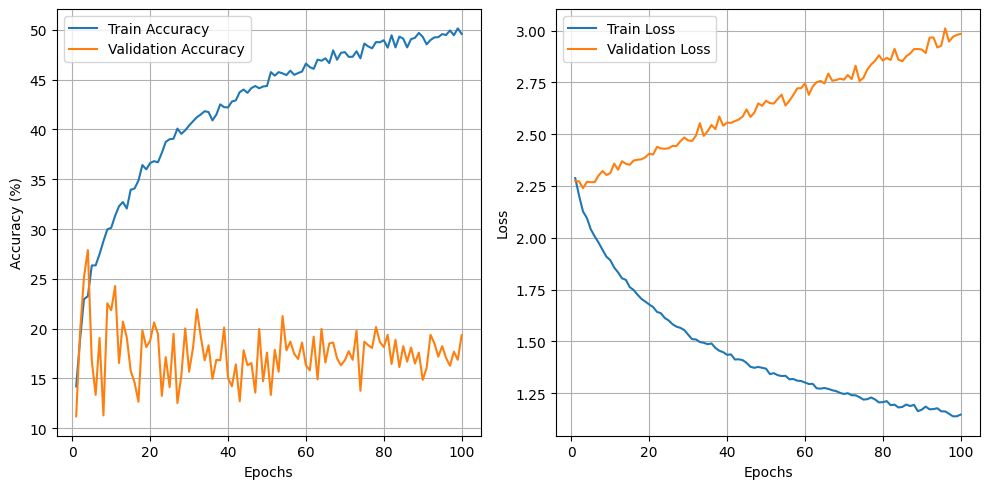

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v5/representacion_3/longitud_8/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/v5/representacion_3/longitud_8/ResNet50_fold_4.pth"))
modelo.to(device)
modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

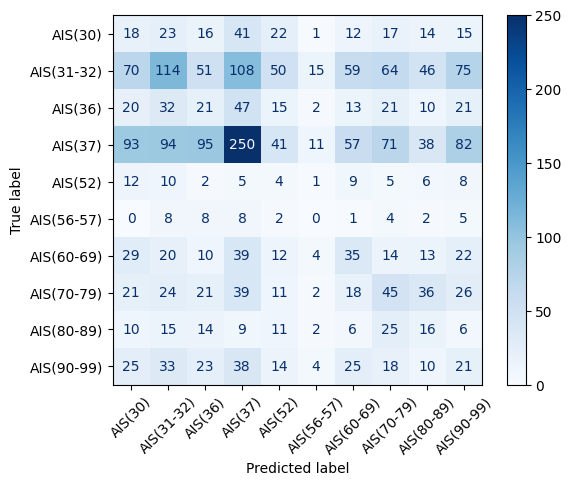

In [12]:
class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
#class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
#class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v5/representacion_3/longitud_8')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ResNet50_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

     AIS(30)       0.06      0.10      0.08       179
  AIS(31-32)       0.31      0.17      0.22       652
     AIS(36)       0.08      0.10      0.09       202
     AIS(37)       0.43      0.30      0.35       832
     AIS(52)       0.02      0.06      0.03        62
  AIS(56-57)       0.00      0.00      0.00        38
  AIS(60-69)       0.15      0.18      0.16       198
  AIS(70-79)       0.16      0.19      0.17       243
  AIS(80-89)       0.08      0.14      0.10       114
  AIS(90-99)       0.07      0.10      0.09       211

    accuracy                           0.19      2731
   macro avg       0.14      0.13      0.13      2731
weighted avg       0.25      0.19      0.21      2731

